# Making Exonet labels for DR25

Last updated: 11 Nov. 2019

In [1]:
import sys, os, pdb, glob, time
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
from tqdm import tqdm_notebook as tqdm

### Load raw tables downloaded from MAST, Exoplanet Archive, etc.

In [2]:
### DR25 TCEs (downloaded from MAST; "rogue" sources removed)
tce_dr25 = Table.read("kplr_tables/q1_q17_dr25_tce.csv", format="csv", comment="#")
tce_dr25 = tce_dr25[tce_dr25["tce_rogue_flag"] == 0]

### DR25 KOI Cumullative table (downloaded from MAST)
koi = Table.read("kplr_tables/koi_cumulative.csv", format="csv", comment="#")

### DR25 Certified FPs (downloaded from the NASA Exoplanet Archive)
# fpwg = Table.read("kplr_tables/fpwg.csv", format="csv", comment="#")

### ROBOVETTER Results (downloaded from GitHub; should match to tce_dr25)
rv_dr25 = Table.read("kplr_tables/kplr_dr25_obs_robovetter_output.txt", format="ascii.basic")

### Stellar properties from Mathur+2017 (downloaded from CDS)
star_dr25 = Table.read("kplr_tables/stellar_mathur_2017.fit", format="fits")

In [3]:
### TBD: remove rogue TCEs from DR25? (due to error in TPS that kept 3-transit events; see explanation in link)
### https://exoplanetarchive.ipac.caltech.edu/docs/Q1Q17-DR25-KOIcompanion.html
### Thompson et al. 2018 encourage community to look at these since they contain some of the longest-period planets

### Initialize DR25 labels table with TCE information

In [4]:
### CREATE TABLE
dr25 = Table()

### FILL WITH USEFUL VALUES FROM TCE TABLE
tce_colnames = ["kepid", "tce_plnt_num", "tce_period", "tce_time0bk", "tce_duration", "tce_max_mult_ev"]
tce_colnames_new = ["kep_id", "tce_id", "period", "epoch", "duration", "mes"]
for i, val in enumerate(tce_colnames_new):
    dr25[val] = tce_dr25[tce_colnames[i]].data.data


### Add stellar paramteers from Mathur et al. 2017

In [5]:
### SETUP MATCHING
starpars_names = ["Teff", "Rad", "Mass", "log_g_", "__Fe_H_", "rho"]
teff, radius, mass, logg, feh, density, missing = [], [], [], [], [], [], []
starpars = [teff, radius, mass, logg, feh, density]

### PERFORM MATCH
for i, val in enumerate(tqdm(dr25["kep_id"])):
    
    ### FIND MATCH TO MATHUR+2017 
    ind = np.where(star_dr25["KIC"] == val)
    
    ### RECORD NON-MATCHES AND REPLACE WITH DUMMY VALUES
    if len(ind[0]) != 1:
        missing.append(val)
        [x.append(-99) for x in starpars]

    ### ELSE GRAB STELLAR PARAMETERS
    else:
        [(x.append(star_dr25[y][ind].data[0])) for x, y in zip(starpars, starpars_names)]

### ADD TO LABELS
starpars_names_new = ['teff', 'radius', 'mass', 'logg', 'feh', 'density']
for i, val in enumerate(starpars):
    dr25.add_column(Column(starpars[i], name=starpars_names[i], format="%.4f"))
    dr25.rename_column(starpars_names[i], starpars_names_new[i])

In [6]:
### FIX MISSING STELLAR VALUES

### HOW MANY ARE MISSING?
print("{0:0.0f} TCEs are missing stellar parameters in Mathur et al. 2017".format(len(missing)))
print("{0:0.0f} are unique KIC IDs \n".format(len(np.unique(missing))))

### THESE ARE ALL KIC STARS WITH UNKNOWN STELLAR PARAMETERS 
ind_solar = np.where(tce_dr25["tce_steff_prov"] == "Solar")
print("These match the {0:0.0f} stars in the TCE list with unknown (Solar) stellar parameters".format(len(ind_solar[0])))
print("For example:\n")
print(tce_dr25["kepid", "tce_steff_prov"][np.where(dr25["teff"] == -99)][0:4])

### REPLACING WITH MEDIAN VALUES
ind_bad = np.where(dr25["teff"] == -99)
ind_good = np.where(dr25["teff"] != -99)
for i, val in enumerate(starpars_names_new):
    dr25[val][ind_bad] = np.median(dr25[val][ind_good])


326 TCEs are missing stellar parameters in Mathur et al. 2017
191 are unique KIC IDs 

These match the 326 stars in the TCE list with unknown (Solar) stellar parameters
For example:

 kepid  tce_steff_prov
------- --------------
2308761          Solar
2308761          Solar
2308761          Solar
2436378          Solar


### Match RoboVetter and TCEs

In [7]:
### SETUP MATCHING
rv_names = ["Robovetter_Score", "Disposition", "Not_Transit-Like_Flag", "Stellar_Eclipse_Flag", 
            "Centroid_Offset_Flag", "Ephemeris_Match_Flag"]
rv_score, rv_disp, rv_ntl, rv_se, rv_co, rv_em, missing = [], [], [], [], [], [], []
rv_pars = [rv_score, rv_disp, rv_ntl, rv_se, rv_co, rv_em]
for i, val in enumerate(tqdm(dr25["kep_id"])):
    
    ### INDEX MATCH TO RV CATALOG BASED ON KIC + TCE ID
    tce_str = str(dr25["kep_id"][i]).zfill(9) + "-" + str(dr25["tce_id"][i]).zfill(2)
    ind = np.where(rv_dr25["TCE"] == tce_str)
    
    ### RECORD ANY MISSING MATCHES AND USE -99 AS DUMMY FILL VALUE
    if len(ind[0]) != 1:
        missing.append(val)
        [x.append(-99) for x in rv_pars]        
        
    #### ELSE RECORD MATCH
    else:
        [(x.append(rv_dr25[y][ind].data[0])) for x, y in zip(rv_pars, rv_names)]

### ADD TO LABELS
rv_names_new = ["rv_score", "rv_disp", "rv_ntl", "rv_se", "rv_co", "rv_em"]
for i, val in enumerate(rv_pars):
    dr25.add_column(Column(rv_pars[i], name=rv_names[i]))
    dr25.rename_column(rv_names[i], rv_names_new[i])
    
### REPORT ANY MISSING MATCHES TO RV (THIS SHOULDN'T HAPPEN)
print("missing RV matches: {0:0.0f}".format(len(missing)))


missing RV matches: 0


### Check RoboVetter against KOI DR 25 table

In [8]:
### cannot use koi_tce_plt_num with koi_tce_delivname = "q1_q17_dr25_tce" in koi table 
### as it doesn't match the tce_plt_num in the q1_q17_dr25_tce table (example is KIC 2012722)

### PERFORM MATCH TO DR25 KOI TABLE
koi_koi, koi_kic, koi_tce = [], [], []
missing_kic, missing_tce = [], []
for i, val in enumerate(tqdm(koi["kepid"])):
        
    ### INDEX MATCHES TO THIS KIC ID
    ind = np.where(dr25["kep_id"] == val)

    ### FIND EPHEM MATCHES USING PERIOD + EPOCH MATCHING OF THOMPSON+2018
    if len(ind[0]) > 0:
                
        ### LOOP OVER ALL POSSIBLE KOIs WITH SAME KIC
        found_pdiff, found_tce = [], []
        for n, nval in enumerate(ind[0]):
                
            ### FIGURE OUT WHICH OBJECT HAS SHORTER PERIOD
            if (dr25["period"][nval] > koi["koi_period"][i]):
                p1, p2 = dr25["period"][nval], koi["koi_period"][i]
                e1, e2 = dr25["epoch"][nval], koi["koi_time0bk"][i]
            else:
                p1, p2 = koi["koi_period"][i], dr25["period"][nval]
                e1, e2 = koi["koi_time0bk"][i], dr25["epoch"][nval]

            ### APPLY CRITERIA FOR PERIOD & EPOCH MATCHING
            prat = round(p1 / p2)
            pdiff = math.fabs(prat * p2 - p1) / (1.08228446E-05 * pow(p2, 1.3783804))
            trat = round((e2  - e1) / p2)
            tdiff = math.fabs(e2  - e1 - trat * p2) / (math.sqrt(2) * 0.00969916 * pow(p2, 0.36253537))

            ### IF MATCH FOUND, RECORD
            if (pdiff < 5.0) & (tdiff < 5.0):
                found_pdiff.append(pdiff)
                found_tce.append(dr25["tce_id"][nval])
        
        ### IF MORE THAN ONE MATCH FOUND, TAKE CLOSEST PERIOD MATCH
        if len(found_pdiff) > 1:            
            koi_tce.append(found_tce[np.argmin(found_pdiff)])
            koi_koi.append(koi["kepoi_name"][i])
            koi_kic.append(koi["kepid"][i])
            
        ### IF ONLY ONE MATCH, RECORD
        elif len(found_pdiff) == 1:
            koi_tce.append(found_tce[0])
            koi_koi.append(koi["kepoi_name"][i])
            koi_kic.append(koi["kepid"][i])
            
        ### IF NO MATCH, RECORD MISSING 
        else:
            missing_tce.append(koi["kepoi_name"][i])
            
    ### ELSE RECORD NO KIC MATCH
    else:
        missing_kic.append(koi["kepoi_name"][i])

### DO SOME CHECKS ON MATCHING
if (len(missing_kic) + len(koi_koi) + len(missing_tce) != len(koi)):
    print("some koi entires were not recorded")

In [9]:
### INVESTIGATE THE MISSING KICS SOURCES
not_dr25, missing_kic_disp = [], []
for i, val in enumerate(tqdm(missing_kic)):
    
    ### FIND THIS KOI
    ind = np.where(koi["kepoi_name"] == val)
    missing_kic_disp.append(koi["koi_disposition"][ind][0])
        
    ### EVERYTHING SHOULD HAVE ONE MATCH
    if len(ind[0]) != 1:
        print("what?", val)
        break
                
    ### CHECK IF IN DR25 TCE TABLE
    if (koi["koi_tce_delivname"][ind].mask == True):
        not_dr25.append(val)
    elif (koi["koi_tce_delivname"][ind].data[0] != "q1_q17_dr25_tce"):
        not_dr25.append(val)
        
    ### OTHERWISE PRINT TO SCREEN
    else:
        print(val)
        
### HOW MANY CAN BE EXPLAINED BY JUST NOT BEING IN DR25
print("{0:0.0f} of the {1:0.0f} missing KOIs are explained by not being in DR25".format(len(not_dr25), len(missing_kic)))

### TBD: Need to figure out why there are sources without TCE delivery names
### and whehter we should include in the training set the TCEs from other DRs.
### There are a lot of candidates in the dataset
missing_kic_disp = np.array(missing_kic_disp)
ind_can = np.where(missing_kic_disp == 'CANDIDATE')
ind_fps = np.where(missing_kic_disp == 'FALSE POSITIVE')
ind_con = np.where(missing_kic_disp == 'CONFIRMED')
print("{0:0.0f} are FPs, {1:0.0f} are candidates, {2:0.0f} are confirmed".format(len(ind_fps[0]), len(ind_can[0]), len(ind_con[0])))



1101 of the 1101 missing KOIs are explained by not being in DR25
654 are FPs, 446 are candidates, 1 are confirmed


In [10]:
### INVESTIGATE THE MISSING TCE SOURCES
not_dr25, missing_tce_disp, what, what_disp = [], [], [], []
for i, val in enumerate(missing_tce):

    ### FIND THIS KOI
    ind = np.where(koi["kepoi_name"] == val)
    missing_tce_disp.append(koi["koi_disposition"][ind][0])
    
    ### EVERYTHING SHOULD HAVE ONE MATCH
    if len(ind[0]) != 1:
        print("what?", val)
        break
        
    ### CHECK IF IN DR25 TCE TABLE
    if (koi["koi_tce_delivname"][ind].mask == True):
        not_dr25.append(val)
    elif (koi["koi_tce_delivname"][ind].data[0] != "q1_q17_dr25_tce"):
        not_dr25.append(val)
        
    ### OTHERWISE RECORD
    else:
        what.append(val)
        what_disp.append(koi["koi_disposition"][ind][0])
        
### HOW MANY CAN BE EXPLAINED BY JUST NOT BEING IN DR25
print("{0:0.0f} of the {1:0.0f} missing KOIs are explained by not being in DR25".format(len(not_dr25), len(missing_tce)))

### TBD: Need to figure out why those with DR25 TCE matches are not being ephemeris matched
### Maybe not importnat since only 7 are confirmed and only 22 are candidates
what_disp = np.array(what_disp)
ind_can = np.where(what_disp == 'CANDIDATE')
ind_fps = np.where(what_disp == 'FALSE POSITIVE')
ind_con = np.where(what_disp == 'CONFIRMED')
print("Of the unexplained {0:0.0f} are FPs, {1:0.0f} are candidates, {2:0.0f} are confirmed".format(len(ind_fps[0]), len(ind_can[0]), len(ind_con[0])))


392 of the 670 missing KOIs are explained by not being in DR25
Of the unexplained 249 are FPs, 22 are candidates, 7 are confirmed


### Fix/update RV dispositions 

In [11]:
### FIND THOSE THAT ARE CONFIRMED KOIs BUT RV FPs 
ind_confirmed_new, koi_confirmed_new = [], []
for i, val in enumerate(koi_koi):
    
    ind_koi = np.where(koi["kepoi_name"] == koi_koi[i])
    ind_tce = np.where( (dr25["kep_id"] == koi_kic[i]) & (dr25["tce_id"] == koi_tce[i]) )
    
    if (koi["koi_disposition"][ind_koi][0] == "CONFIRMED") & (dr25["rv_disp"][ind_tce][0] == "FP"):
        ind_confirmed_new.append(ind_tce[0][0])
        koi_confirmed_new.append(val)
        
ind_confirmed_new = np.array(ind_confirmed_new)
koi_confirmed_new = np.array(koi_confirmed_new)
print("{0:0.0f} newly confirmed planets classified as FPs by RV".format(len(ind_confirmed_new)))

40 newly confirmed planets classified as FPs by RV


In [12]:
### CREATE LABELS WITH UPDATES FROM KOI
dr25["label"] = dr25["rv_disp"].data
dr25["label"][ind_confirmed_new] = "PC"

print("{0:0.0f} planets".format(len(np.where(dr25["label"] == "PC")[0])))
print("{0:0.0f} FPs".format(len(np.where(dr25["label"] != "PC")[0])))

### TBD: HOW TO REMOVE THE "UNK" CLASS FROM AV (SEE BELOW; UNCLEAR IF THEY CORRESPOND TO ANY SPECIFIC RV LABEL)

4077 planets
28457 FPs


In [14]:
### WRITE LABELS TO FILE
dr25["kep_id", "tce_id", "period", "epoch", "duration", "mes", "teff", "radius", "mass", "logg", "feh", "density", "label"].write("dr25_labels.txt", format='ascii.csv')

# Differences between DR24 and DR25 TCE Table

### Fix/Check TCE Table

In [2]:
### DR24-DR25 matches (from Chris Burke using his Federation code, 5 Nov. 2019)
tce_dr24_dr25 = Table.read("kplr_tables/DR24-DR25-TCE-TCE-Pairs.txt", format="ascii.no_header")
tce_dr24_dr25["col1"].name = "DR24_TCE"
tce_dr24_dr25["col2"].name = "DR25_TCE"

### DR25 TCEs (downloaded from MAST; "rogue" sources removed)
tce_dr25 = Table.read("kplr_tables/q1_q17_dr25_tce.csv", format="csv", comment="#")
tce_dr25 = tce_dr25[tce_dr25["tce_rogue_flag"] == 0]

### DR25 TCEs (downloaded from MAST; "rogue" sources removed)
tce_dr24 = Table.read("kplr_tables/q1_q17_dr24_tce.csv", format="csv", comment="#")

### ROBOVETTER Results (downloaded from GitHub; should match to tce_dr25)
rv_dr25 = Table.read("kplr_tables/kplr_dr25_obs_robovetter_output.txt", format="ascii.basic")


In [4]:
### SETUP MATCHING
rv_names = ["Robovetter_Score", "Disposition", "Not_Transit-Like_Flag", "Stellar_Eclipse_Flag", 
            "Centroid_Offset_Flag", "Ephemeris_Match_Flag"]
rv_score, rv_disp, rv_ntl, rv_se, rv_co, rv_em, missing = [], [], [], [], [], [], []
rv_pars = [rv_score, rv_disp, rv_ntl, rv_se, rv_co, rv_em]
for i, val in enumerate(tqdm(tce_dr25["kepid"])):
    
    ### INDEX MATCH TO RV CATALOG BASED ON KIC + TCE ID
    tce_str = str(tce_dr25["kepid"][i]).zfill(9) + "-" + str(tce_dr25["tce_plnt_num"][i]).zfill(2)
    ind = np.where(rv_dr25["TCE"] == tce_str)
    
    ### RECORD ANY MISSING MATCHES AND USE -99 AS DUMMY FILL VALUE
    if len(ind[0]) != 1:
        missing.append(val)
        [x.append(-99) for x in rv_pars]        
        
    #### ELSE RECORD MATCH
    else:
        [(x.append(rv_dr25[y][ind].data[0])) for x, y in zip(rv_pars, rv_names)]

### ADD TO LABELS
rv_names_new = ["rv_score", "rv_disp", "rv_ntl", "rv_se", "rv_co", "rv_em"]
for i, val in enumerate(rv_pars):
    tce_dr25.add_column(Column(rv_pars[i], name=rv_names[i]))
    tce_dr25.rename_column(rv_names[i], rv_names_new[i])
    
### REPORT ANY MISSING MATCHES TO RV (THIS SHOULDN'T HAPPEN)
print("missing RV matches: {0:0.0f}".format(len(missing)))


missing RV matches: 0


In [5]:
ind_dr24_match, ind_dr25_match = [], []
for i, val in enumerate(tqdm(tce_dr25)):
    
    ### INDEX MATCH TO RV CATALOG BASED ON KIC + TCE ID
    tce_str_dr25 = str(tce_dr25["kepid"][i]).zfill(9) + "-" + str(tce_dr25["tce_plnt_num"][i]).zfill(2)
    ind_tce = np.where(tce_dr24_dr25["DR25_TCE"] == tce_str_dr25)
    
    if len(ind_tce[0]) == 1:
        
        tce_str_dr24 = tce_dr24_dr25["DR24_TCE"][ind_tce][0]
        kic = int(tce_str_dr24.split("-")[0])
        tce = int(tce_str_dr24.split("-")[1])
    
        ind_dr24 = np.where( (tce_dr24["kepid"] == kic) & (tce_dr24["tce_plnt_num"] == tce) )
        if len(ind_dr24[0]) == 0:
            print(tce_str_dr25, tce_str_dr24)
        else:
            ind_dr24_match.append(ind_dr24[0][0])
            ind_dr25_match.append(i)

ind_dr24_match =  np.array(ind_dr24_match)
ind_dr25_match =  np.array(ind_dr25_match)



005513861-01 005513861-01
008019043-01 008019043-01
008019043-02 008019043-02
008019043-03 008019043-03



In [6]:
### ONLY KEEP THOSE WITH MATCHES FROM DR24 TO DR25
dr24 = tce_dr24[ind_dr24_match]
dr25 = tce_dr25[ind_dr25_match]

In [57]:
### MOST OF THE UNK CLASS SEEMS TO BE FP DUE TO NTL EVENTS
### THERE ARE A COUPLE HUNDRED PCs THAT WERE PREVIOUSLY CLASSIFIED AS UNK AND THUS NOT USED FOR DR24 TRAINING

ind_av_unk = np.where(dr24["av_training_set"] == "UNK")
pc_unk = []
for i, val in enumerate(ind_av_unk[0]):
    
    if dr25["rv_disp"][val] != "FP":
        tce_str = str(dr25["kepid"][val]).zfill(9) + "-" + str(dr25["tce_plnt_num"][val]).zfill(2)
        pc_unk.append(tce_str)
        
#     print(dr25["kepid"][val], dr25["tce_plnt_num"][val], dr25["rv_disp"][val],
#           dr25["rv_ntl"][val], dr25["rv_se"][val], dr25["rv_co"][val], dr25["rv_em"][val])
        
pc_unk = np.array(pc_unk)
print("{0:0.0f} out of {1:0.0f} TCEs classified as UNK in DR24 are now PCs in DR25".format(len(pc_unk), len(ind_av_unk[0])))


226 out of 2030 TCEs classified as UNK in DR24 are now PCs in DR25


In [58]:
### BUT THERE ARE ALSO A BUNCH OF NTL FPS THAT ARE NOT UNK
ind_av_unk = np.where(dr24["av_training_set"] == "UNK")
ind_av_knw = np.where(dr24["av_training_set"] != "UNK")

print(len(np.where(dr25["rv_ntl"][ind_av_unk] == 1)[0]))
print(len(np.where(dr25["rv_ntl"][ind_av_knw] == 1)[0]))

1426
4277


In [68]:
dr24["kepid", "tce_plnt_num", "tce_period", "av_training_set"][0:15]

kepid,tce_plnt_num,tce_period,av_training_set
int64,int64,float64,str3
2304235,1,0.570592,AFP
2304566,1,0.689907,UNK
2304320,1,16.5408,PC
2303365,2,0.520697,AFP
2303903,1,3.70852,PC
2303365,1,0.520683,AFP
2305255,1,24.5694,NTP
757450,1,8.88492,PC
892772,1,5.0926,AFP


In [69]:
dr25["kepid", "tce_plnt_num", "tce_period", "rv_disp", "rv_ntl"][0:15]

kepid,tce_plnt_num,tce_period,rv_disp,rv_ntl
int64,int64,float64,str2,int64
2304235,1,0.570607,FP,1
2304566,1,0.68948,FP,1
2304320,1,16.5408,PC,0
2303365,2,0.520697,FP,1
2303903,1,3.70856,PC,0
2303365,1,0.520693,FP,1
2305255,1,24.5694,FP,1
757450,1,8.88492,PC,0
892772,1,5.09259,FP,0


### compare DR24 and DR25 TCEs [see Fig. 1 in Thompson et al. 2018]

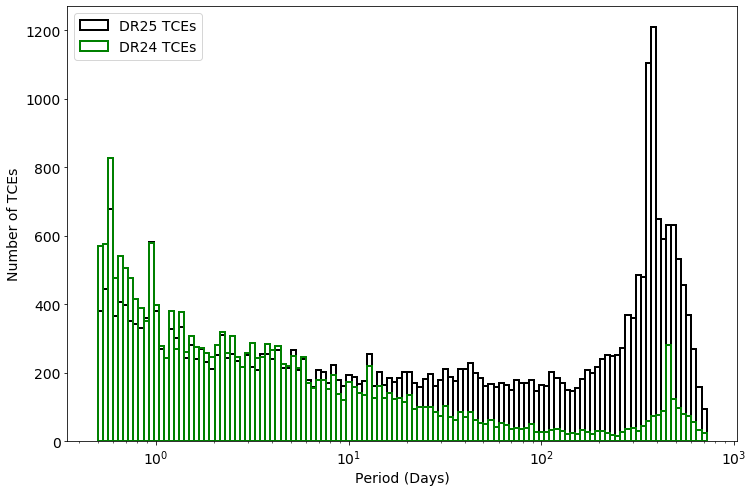

In [218]:
### setup plot
plt.rcParams.update({'font.size': 14})
fig=plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')

### get bins equally spaced in log space
x = tce_dr25['tce_period'].data
hist, bins, _ = plt.hist(x, bins=120)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.clf() 

### plot histogram of TCEs
plt.xscale('log')
plt.xlabel("Period (Days)")
plt.ylabel("Number of TCEs")
plt.hist(x, bins=logbins, fill=False, edgecolor='black', linewidth=2, label='DR25 TCEs')
plt.hist(tce_dr24['tce_period'].data, bins=logbins, fill=False, edgecolor='green', linewidth=2, label='DR24 TCEs')

plt.legend()

Looks good (i.e., similar to Fig. 1 in Thompson et al. 2018). Note that the increase in TCEs in DR25 are mostly false positives, which was done on purpose to increase the Pipeline completeness by allowing more transiting exoplanets to be made into obsTCEs.(see Thompson et al. 2018 for explanation). 

### compare SV18-DR24-AV training set to RV-DR25 training set

Only ~440 (12%) more PCs, but much more negative classifications (i.e., more unbalanced dataset)

In [235]:
'''
[from Catanzarite et al. 2015]

The robovetter PC class is almost the same as that of the autovetter.
 The only difference is AV autovetter defines PC to have radius smaller than 25 REarth.

The robovetter Transit-like FP class (i.e, those that become KOIs) is a subset of AV's AFP class.
AV also include TCEs produced by periodic signals of astrophysical origin
(e.g., due to pulsating stars, contact binaries and starspots)
that the robovetter would classify these as Not Transit-Like.
 
'''

### SV18 training set from 
ind_sv_all = np.where(tce_dr24['av_training_set'] != 'UNK')
ind_sv_pc = np.where(tce_dr24['av_training_set'] == 'PC')
print("\ntotal SV18 training set = ", len(ind_sv_all[0]))
print("PC in SV18 training set = ", len(ind_sv_pc[0]), 'or', 100 * round(len(ind_sv_pc[0]) / len(ind_sv_all[0]), 2), '%')

### RV training set
## remove ephem matches (these shouldn't be in training set since not in SV18 I think)
tce25 = dr25[np.where(dr25['rv_em'] == 0)]
print("\ntotal DR25 training set = ", len(tce25))
print("PC in DR25 training set = ", len(np.where(tce25['label'] == 'PC')[0]), 'or', 
      100 * round(len(np.where(tce25['label'] == 'PC')[0]) / len(tce25), 2), '%')



total SV18 training set =  15737
PC in SV18 training set =  3600 or 23.0 %

total DR25 training set =  30690
PC in DR25 training set =  4077 or 13.0 %


### Fix/Check KOI Table

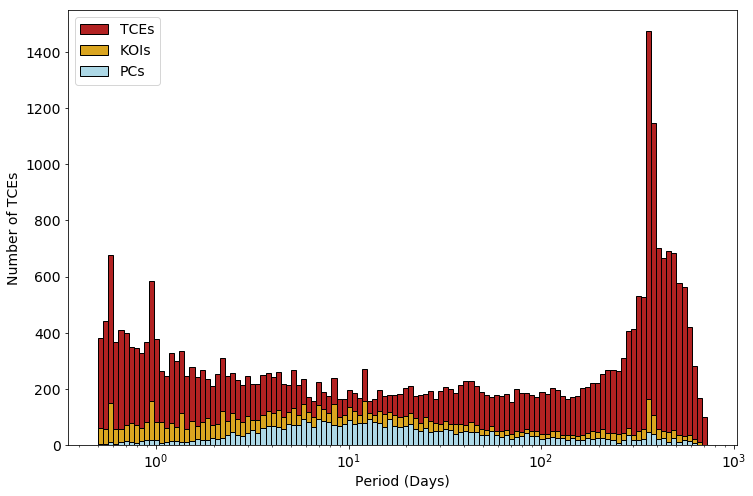

In [7]:
### try to re-create plots in 
### https://exoplanetarchive.ipac.caltech.edu/docs/Q1Q17-DR25-KOIcompanion.html

### setup plot
plt.rcParams.update({'font.size': 14})
fig=plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')

### get bins equally spaced in log space
x = tce25['tce_period'].data
hist, bins, _ = plt.hist(x, bins=120)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.clf() 

### plot histogram of TCEs
plt.xscale('log')
plt.xlabel("Period (Days)")
plt.ylabel("Number of TCEs")
plt.hist(x, bins=logbins, color='firebrick', edgecolor='black', linewidth=1, label='TCEs')

### plot histogram of KOIs
x_koi = koi25['koi_period'].data
plt.hist(x_koi, bins=logbins, color='goldenrod', edgecolor='black', linewidth=1, label='KOIs')

### plot histogram of PCs
x_pc = koi25['koi_period'][np.where(koi25['koi_pdisposition'] == 'CANDIDATE')].data
plt.hist(x_pc, bins=logbins, color='lightblue', edgecolor='black', linewidth=1, label='PCs')

plt.legend()


The total number of DR25 TCEs with KOI labels is < len(KOI) because some were delivered in earlier releases

In [26]:
ind_all = np.where(tce25['koi_disposition'] != '')
ind_pc = np.where( (tce25['koi_disposition'] == 'CANDIDATE') | (tce25['koi_disposition'] == 'CONFIRMED') )

print("total KOIs = ", len(koi25))
print("total training set = ", len(ind_all[0]))
print("PC in training set = ", len(ind_pc[0]), 'or', 100 * round(len(ind_pc[0]) / len(ind_all[0]), 2), '%')

total KOIs =  9564
total training set =  8187
PC in training set =  4154 or 51.0 %
